# Tumor Detection With Transfer Learning

In this article, I show how to take a general purpose image classification model (Xception in this instance), and train it to specialize in a specific task (detecting tumors in brain scans).

I obtained a [data-set from GitHub](https://github.com/guillaumefrd/brain-tumor-mri-dataset). The data included only two classes: brain-scans with tumors and brain-scans without. A typical image of a brain with a tumor looks like this:

<center><img src="./data/train/yes/Y37.jpg" alt="tumor" width="250"/></center>

A typical image of a healthy brain looks like this:

<center><img src="./data/train/no/27 no.jpg" alt="tumor" width="250"/></center>

## Getting Started

We start the project by clearing our session and setting random seeds.


In [30]:
# Clear the session and fix the random seeds for reproducibility

from tensorflow.keras.backend import clear_session
from tensorflow.random import set_seed
from numpy.random import seed

clear_session()
set_seed(4006) # comment out to use random seed
seed(4006) # comment out to use random seed

Next, we create an augmented data set that uses the the `ImageDataGenerator` function to generate images that are randomely rotated, cropped and resized to varying degrees (the training set is subjected to greater modification than the validation set, and the test set is unmodified, so that it is a fair assessment of real performance).

In [4]:
# create an augmented training data set

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input

datagen_train = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   preprocessing_function=preprocess_input)

datagen_val = ImageDataGenerator(rotation_range=5,
                                 zoom_range=0.2,
                                 preprocessing_function=preprocess_input)

datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen_train.flow_from_directory('./data/train',
                                              target_size=(224,224),
                                              color_mode='rgb',
                                              batch_size=20,
                                              class_mode='categorical',
                                              shuffle=True)

val_gen = datagen_val.flow_from_directory('./data/validate',
                                          target_size=(224,224),
                                          color_mode='rgb',
                                          batch_size=10,
                                          class_mode='categorical',
                                          shuffle=True)

test_gen = datagen_test.flow_from_directory('./data/test',
                                            target_size=(224,224),
                                            color_mode='rgb',
                                            batch_size=5,
                                            class_mode='categorical',
                                            shuffle=True)


n_classes = train_gen.num_classes

train_gen.n

Found 190 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


190

## Transfer Learning

First, we create creating a base model from the Xception architecture, with its top layer removed. In the Keras API, you can remove the top layer of any architecture by setting the variable `include_top` to `True`, as see below in `# [1]`. Then we add a pooling layer, a dropout layer (20%) and a dense output layer using the Keras functional API, which allows you to define layers as functions, which take other layers as inputs. We then freeze the model and early stopping / model checkpoints, which save the model and stop when training nolonger appreciably improves the model.

If you want to remove more than the top layer, you can look at the structure of the model using `<model_name>.summary` and then you can use a  for loop to make a list of all the layers in the model up to your stopping point, and then you can put the list into the `keras.models.sequential` function to obtain a model. From there, you can proceed as shown in the cell below.


In [31]:
# define a model 


from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Model
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True) 

# take Xception without its output layer as the base model
base_model = Xception(weights="imagenet", include_top=False) # [1]
# add a global average pooling layer
avg = GlobalAveragePooling2D()(base_model.output)
# next, adding an MCDropout layer before the output layer to reduce risk of over-fitting.
dropout = MCDropout(rate=0.2)(avg) # dropout is not standard, remove if breaks
dense = Dense(2*n_classes, activation="relu")(dropout)
output = Dense(n_classes, activation="softmax")(dense) # change dropout to avg if broken
model = Model(inputs=base_model.input, outputs=output)




# freeze the model


for layer in base_model.layers: # freeze layers in base_model
    layer.trainable = False




# set up model saving and early stopping


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping_cb = EarlyStopping(patience=20)
model_checkpoint_cb = ModelCheckpoint("model.h5", save_best_only=True)
cb_list = [early_stopping_cb, model_checkpoint_cb]

Next, we train the top layers only, with Xception frozen, using a learning rate of 0.2.

In [32]:
# train top layer with lower layers frozen

from tensorflow.keras.optimizers import SGD
# import pandas as pd


optimizer_top = SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer_top,
              metrics=["accuracy"])
history_top = model.fit(train_gen,
                              epochs=20,
                              validation_data=val_gen,
                              callbacks=cb_list)

/home/oliver/ke/sta/venvs/tumors/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
10/10 [==============================] - 14s 1s/step - loss: 237.6979 - accuracy: 0.5368 - val_loss: 427.3730 - val_accuracy: 0.6000
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 289.2325 - accuracy: 0.6947 - val_loss: 316.8285 - val_accuracy: 0.6500
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 153.8211 - accuracy: 0.7368 - val_loss: 109.8675 - val_accuracy: 0.7000
Epoch 4/20
10/10 [==============================] - 16s 2s/step - loss: 125.8788 - accuracy: 0.6368 - val_loss: 136.1484 - val_accuracy: 0.6250
Epoch 5/20
10/10 [==============================] - 16s 2s/step - loss: 96.9785 - accuracy: 0.6684 - val_loss: 114.0743 - val_accuracy: 0.6250
Epoch 6/20
10/10 [==============================] - 16s 2s/step - loss: 117.8752 - accuracy: 0.7263 - val_loss: 191.4532 - val_accuracy: 0.5500
Epoch 7/20
10/10 [==============================] - 16s 2s/step - loss: 148.7172 - accuracy: 0.6053 - val_loss: 149.7275 - val_accuracy: 

Finally, we train the entire model (with Xception unfrozen) using a much smaller learning rate (0.0001).

In [33]:
# train whole model with safe learning rate
# (so as not to overwhelm the pretrained weights)

# Tried lr=0.01 and decay=0.001, but error went to NAN levels.
# Tried lr=0.005 and decay=0.0005.
# Tried lr=0.001 and decay=0.0001, but loss still went to NAN.
# Switched from VGG19 to Xception model, and everything worked out well at 0.001.

for layer in base_model.layers: # for each layer in the model
    layer.trainable = True # unfreeze it

optimizer_safe = SGD(lr=0.001, momentum=0.9, decay=0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer_safe,
              metrics=["accuracy"])
history_safe = model.fit(train_gen,
                              epochs=10, #15
                              validation_data=val_gen,
                              callbacks=cb_list)

Epoch 1/10
10/10 [==============================] - 65s 6s/step - loss: 2.1301 - accuracy: 0.7263 - val_loss: 5.0712 - val_accuracy: 0.7250
Epoch 2/10
10/10 [==============================] - 63s 6s/step - loss: 0.9847 - accuracy: 0.8158 - val_loss: 1.9765 - val_accuracy: 0.8750
Epoch 3/10
10/10 [==============================] - 63s 6s/step - loss: 0.2447 - accuracy: 0.9368 - val_loss: 0.5090 - val_accuracy: 0.9500
Epoch 4/10
10/10 [==============================] - 62s 6s/step - loss: 0.2635 - accuracy: 0.9053 - val_loss: 1.0039 - val_accuracy: 0.8250
Epoch 5/10
10/10 [==============================] - 62s 6s/step - loss: 0.2579 - accuracy: 0.8947 - val_loss: 0.4332 - val_accuracy: 0.9000
Epoch 6/10
10/10 [==============================] - 61s 6s/step - loss: 0.1480 - accuracy: 0.9526 - val_loss: 0.3617 - val_accuracy: 0.9000
Epoch 7/10
10/10 [==============================] - 62s 6s/step - loss: 0.0916 - accuracy: 0.9737 - val_loss: 0.2036 - val_accuracy: 0.9500
Epoch 8/10
10/10 [==

The performance of the model, as seen below

In [34]:
# Evaluate the model on the test set

evaluation = model.evaluate(test_gen)

4/4 [==============================] - 1s 227ms/step - loss: 0.6421 - accuracy: 0.9000
[0.642116904258728, 0.8999999761581421]


is fairly strong, with 90% accuracy.

## Plotting Our Results

We plot training graphs for the loss and accuracy of the model in its two training phases.

/tmp/ipykernel_1785155/3452793627.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


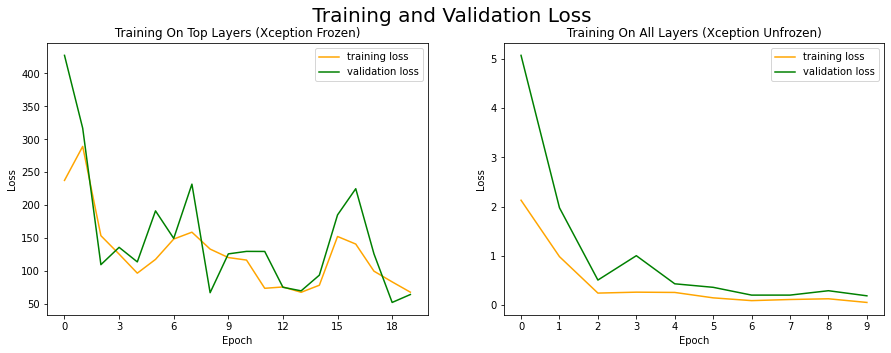

In [42]:
# Plot the training and validation loss

from matplotlib import pyplot as plt

figure, axis = plt.subplots(1, 2, figsize=(15, 5))

figure.suptitle(" Training and Validation Loss ", fontsize=20)

axis[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axis[0].plot(history_top.history["loss"], label="training loss", color="orange")
axis[0].plot(history_top.history["val_loss"], label="validation loss", color="green")
axis[0].set_xlabel("Epoch")
axis[0].set_ylabel("Loss")
axis[0].legend()
axis[0].set_title(" Training On Top Layers (Xception Frozen) ")

axis[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axis[1].plot(history_safe.history["loss"], label="training loss", color="orange")
axis[1].plot(history_safe.history["val_loss"], label="validation loss", color="green")
axis[1].set_xlabel("Epoch")
axis[1].set_ylabel("Loss")
axis[1].legend()
axis[1].set_title(" Training On All Layers (Xception Unfrozen) ")

figure.show()

plt.savefig("loss.png")

/tmp/ipykernel_1785155/3915815676.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


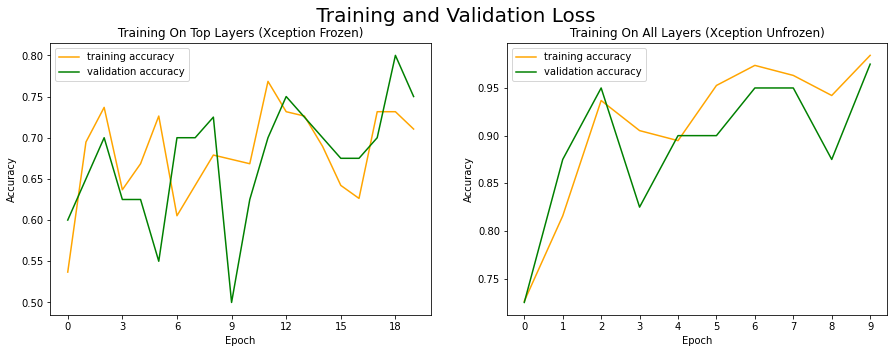

In [41]:
# Plot the training and validation loss

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

figure, axis = plt.subplots(1, 2, figsize=(15, 5))

figure.suptitle(" Training and Validation Loss ", fontsize=20)

axis[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axis[0].plot(history_top.history["accuracy"], label="training accuracy", color="orange")
axis[0].plot(history_top.history["val_accuracy"], label="validation accuracy", color="green")
axis[0].set_xlabel("Epoch")
axis[0].set_ylabel("Accuracy")
axis[0].legend()
axis[0].set_title(" Training On Top Layers (Xception Frozen) ")

axis[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axis[1].plot(history_safe.history["accuracy"], label="training accuracy", color="orange")
axis[1].plot(history_safe.history["val_accuracy"], label="validation accuracy", color="green")
axis[1].set_xlabel("Epoch")
axis[1].set_ylabel("Accuracy")
axis[1].legend()
axis[1].set_title(" Training On All Layers (Xception Unfrozen) ")

figure.show()

plt.savefig("accuracy.png")

Our transfer learning procedure has repurposed the Xception model architecture for diagnosing brain tumors, and we obtained a 90% out of sample accuracy score. Clearly, this model would not be viable as a substitute for doctor expertise. However, these kinds of models can serve as an aid to overworked professionals, and, with more resources, can often achieve very high levels of accuracy and recall.